In [1]:
import os
MainDir=  "/home/andrewoc98/Cs4287/DATA_08_11/"#Main folder that holds all the files
DataDir= "/home/andrewoc98/Cs4287/DATA_08_11/Maps/" #Directory that holds map files
PlayerDir="/home/andrewoc98/Cs4287/DATA_08_11/Players/" # Directory that holds player files

if not os.path.exists(DataDir):
    os.makedirs(DataDir)
    for file in os.listdir(MainDir):
        if file[0:3]=="map_" :
            os.rename(MainDir+file, DataDir+file)
if not os.path.exists(PlayerDir):
    os.makedirs(PlayerDir)
    for file in os.listdir(MainDir):
        if file[0:3]=="play":
            os.rename(MainDir+file, PlayerDir+file)  

In [2]:
#Mirror flips the array as if it was mirrored
def mirror(seq):
    output = list(seq[::-1])
    output.extend(seq[1:])
    return output

#Pixeloffset swaps the first pixel that is not 'empty' and swaps it with the previous entry in the array
def pixeloffset(seq):
    loopBreaker= False
    for i in range(len(seq)):
        for j in range(len(seq[i])):
            if seq[i][j] !=0 or seq[i][j] !="0":
                seq[i][j-1]=seq[i][j-1]
                seq[i][j]=0
                loopBreaker=True
                break
        if loopBreaker==True:
            break
    return seq


#Channeler Splits the map in 5 seperate arrays where each level contains one kind of information i.e ch1 is healthpacks
def Channeler(seq):
    ch1=np.zeros((49,49))
    ch2=np.zeros((49,49))
    ch3=np.zeros((49,49))
    ch4=np.zeros((49,49))
    ch5=np.zeros((49,49))
    for c in range(1,len(ch1)):
            for cc in range(1,len(ch1[c])):
                
                if seq[c][cc]==10 or seq[c][cc]=="10":
                    ch1[c][cc]=10
                if seq[c][cc]==9 or seq[c][cc]=="9":
                    ch2[c][cc]=9
                if seq[c][cc]==8 or seq[c][cc]=="8":
                    ch3[c][cc]=8
                if seq[c][cc]==2 or seq[c][cc]=="2":
                    ch4[c][cc]=2
                if seq[c][cc]==1 or seq[c][cc]=="1":
                    ch5[c][cc]=1
    return np.dstack((ch1,ch2,ch3,ch4,ch5))
            

In [3]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
import pandas as pd

#Declaring Varibles
Collection={} #Is a dictionary that holds both the map id and the map format is mapid:map
RegularMapArray=[] #Contains the 2 array version of the maps

#Loading in map data
for file in os.listdir(DataDir):
    with open(DataDir+file) as csvfile:
        file=file[4:len(file)-4]
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONE)
        files= list(reader)
        RegularMapArray.append(files)
        Collection.update({file:Channeler(files)})

In [4]:
#Loading in Player data
PlayerStats=[] # blank list that details will be appended to

#Looping through directory
for file in os.listdir(PlayerDir):
    with open(PlayerDir+file) as csvfile:
        #Removing all null variables
        reader = csv.reader(x.replace('\0', '') for x in csvfile)
        PlayerStats.append(list(reader))
        
        
 #Player array fromat is PlayerStats[File][Row][Column]      

In [5]:
#Removing all empty parts of the Array
j=0
emptyList=[[]]
for i in range(len(PlayerStats)):
    if PlayerStats[i]==emptyList:
        j=j+1
for i in range(j):
    PlayerStats.remove(emptyList)   

In [6]:
#Assinging a Winrate to all aplicable maps

UserStatsArray=[]#List containing lists of winrates and maps in this format [[Winrate,Map],[Winrate,map]...] 
UnUsedMaps=[]#List of maps that are not in the directory
counter=0#Counter 

#loops Through all player details
for i in range(len(PlayerStats)):
    for counter in range(1, len(PlayerStats[i])-1):
        WinRate=0
        WinRate=(int(PlayerStats[i][counter][1]))/(int(PlayerStats[i][counter][1])+int(PlayerStats[i][counter][2])+int(PlayerStats[i][counter][3]))
        
        #Trys to append to the the map associated with the id and if it is not availible I add the id to an array
        try:
            UserStatsArray.append([Collection[PlayerStats[i][counter][0]],WinRate])
        except:
            UnUsedMaps.append(PlayerStats[i][counter][0])  

In [7]:
#Data Augmentation
OtherCollection={}

#Mirrors first set of maps in the data set an asssigns that mirrored map the same winrate as the original map 
for i in range(int(len(UnUsedMaps)/2)):
        files= mirror(RegularMapArray[i])
        OtherCollection.update({UnUsedMaps[i]:Channeler(files)})
        
#Preforms a pixel offset first set of maps in the data set an asssigns that mirrored map the same winrate as 
#the original map        
for i in range(int(len(UnUsedMaps)/2),len(UnUsedMaps)):
    files= pixeloffset(RegularMapArray[i])
    OtherCollection.update({UnUsedMaps[i]:Channeler(files)})
i=0
#appends these new maps to th userStatsArray
for key in OtherCollection:
    UserStatsArray.append([OtherCollection[key],UserStatsArray[i][1]])
    i=i+1

In [26]:
#Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import time
from sklearn.model_selection import train_test_split

i=0#counter
x=[]#Training
y=[]#Testing
 

#After running model.fit() open a new terminal in a terminal navigate to the folder that this file exists in and
#paste the following command: tensorboard --logdir='log/'
#clisk the localhost link it gives you
NAME="PlayerWinRate-{}".format(int(time.time()))
tensorboard =TensorBoard(log_dir='log/{}'.format(NAME))

checkpoint_filepath = '/tmp/checkpoint'
BestFit = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

#spliting the test data and the labels
for i in range(len(UserStatsArray)):
    x.append(UserStatsArray[i][0])
    y.append(UserStatsArray[i][1])

#spliting the prediction set
X_Train, X_Test, Y_Train, Y_Test = train_test_split(x,y, test_size=0.2, random_state=42) 

#Model Making
model= Sequential()
model.add(Conv2D(64,(5), input_shape =(49,49,5) ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(5)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="mse",
             optimizer="adam",
             metrics=['mae'])

X_Train=np.asarray(X_Train)
Y_Train=np.asarray(Y_Train)

#includes an early stop method to avoid anyoverfitting
history=model.fit(X_Train,
          Y_Train, 
          batch_size=60, 
          epochs=10,
          verbose=1, 
          validation_split=0.2, 
          callbacks=[tensorboard,BestFit,EarlyStopping(monitor='val_loss', patience=2)]
         )

Epoch 1/10
127/127 [==============================] - 49s 389ms/step - loss: 0.0409 - mae: 0.1628 - val_loss: 0.0360 - val_mae: 0.1553
Epoch 2/10
127/127 [==============================] - 53s 415ms/step - loss: 0.0367 - mae: 0.1542 - val_loss: 0.0348 - val_mae: 0.1496
Epoch 3/10
127/127 [==============================] - 50s 397ms/step - loss: 0.0339 - mae: 0.1482 - val_loss: 0.0322 - val_mae: 0.1445
Epoch 4/10
127/127 [==============================] - 49s 383ms/step - loss: 0.0304 - mae: 0.1395 - val_loss: 0.0315 - val_mae: 0.1422
Epoch 5/10
127/127 [==============================] - 51s 402ms/step - loss: 0.0289 - mae: 0.1352 - val_loss: 0.0308 - val_mae: 0.1407
Epoch 6/10
127/127 [==============================] - 57s 448ms/step - loss: 0.0258 - mae: 0.1277 - val_loss: 0.0311 - val_mae: 0.1398
Epoch 7/10
127/127 [==============================] - 42s 335ms/step - loss: 0.0226 - mae: 0.1191 - val_loss: 0.0312 - val_mae: 0.1401


In [27]:
X_Test=np.asarray(X_Test)
Y_Test=np.asarray(Y_Test)
TestPredictions =model.predict(X_Test,batch_size=32, verbose=1)
print(TestPredictions)

75/75 [==============================] - 3s 36ms/step
[[0.46493828]
 [0.55005705]
 [0.5140857 ]
 ...
 [0.5161222 ]
 [0.5069793 ]
 [0.3151585 ]]


In [28]:
#comparison of predictions and actual win rates
print(Y_Test)

[0.085      0.674      0.57309942 ... 0.513      0.517      0.288     ]


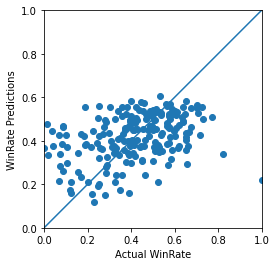

In [29]:
# this scatter plot compare the predicted winRate vs the Actual winrate the ideal placement on
# the ideal place on the graph is directly through the line
plt.scatter(Y_Test[:200], TestPredictions[:200])
plt.xlabel('Actual WinRate')
plt.ylabel('WinRate Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
_=plt.plot([-100,100],[-100,100])

In [36]:
def plot_loss(history):
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.ylim([0.1, .2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

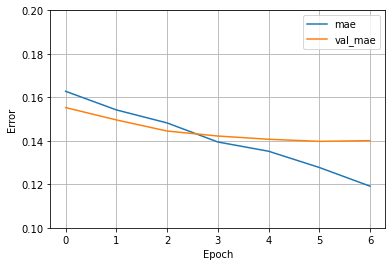

In [37]:
plot_loss(history)